In [17]:
import torch
import matplotlib.pyplot as plt

In [18]:
words = open('names.txt', 'r').read().splitlines()

chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for i, s in enumerate(chars)}
num_chars = len(chars)

### Bigram Count Approach

In [19]:
# Bigram counts.
B = torch.zeros((num_chars, num_chars), dtype=torch.int32)
for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        B[stoi[char1], stoi[char2]] += 1

(-0.5, 26.5, 26.5, -0.5)

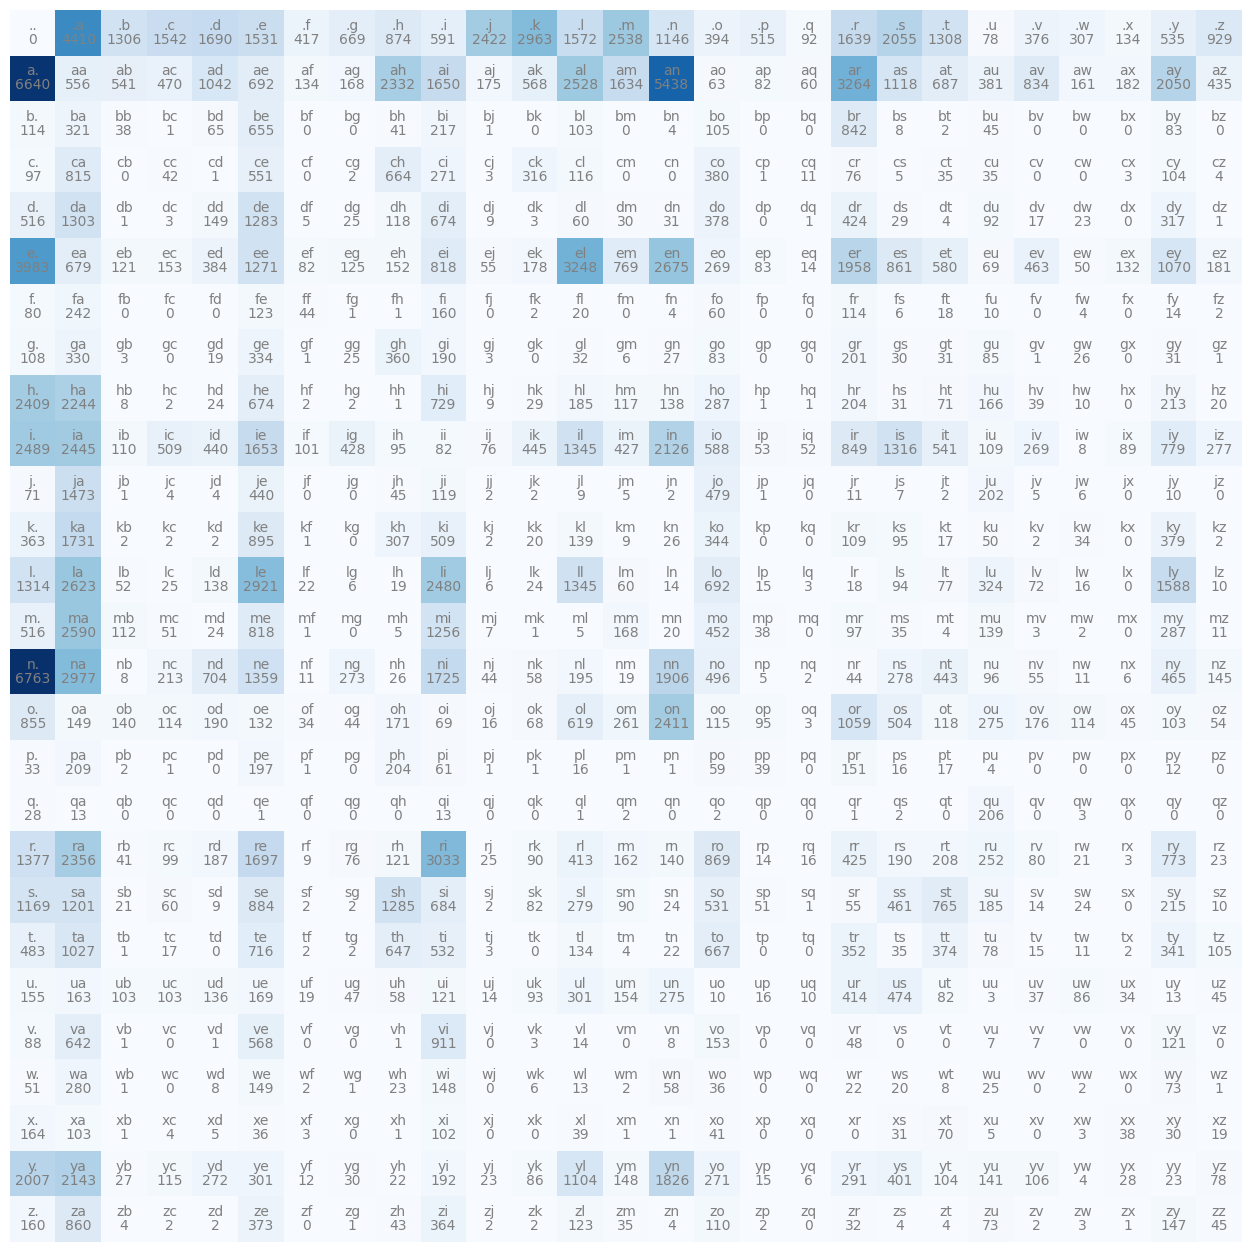

In [20]:
# Visualising the bigram tensor.
plt.figure(figsize=(16,16))
plt.imshow(B, cmap='Blues')
for i in range(B.size(0)):
    for j in range(B.size(1)):
        plt.text(j, i, itos[i] + itos[j], ha='center', va='bottom', color='gray')
        plt.text(j, i, B[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [21]:
# Calculate the probabilities of the next character in the bigram. Summing and normalising across each row.
# Add model smoothing by adding 1 to each bigram. This removes posibility of an average negative log likelihood of inf.
P = (B + 1) / B.sum(1, keepdim=True)

# Loss function. Average negative log likelihood.
log_likelihood = 0
n = 0
for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        prob = P[stoi[char1], stoi[char2]]
        log_likelihood += torch.log(prob)
        n += 1
        
print(f'Loss: {-log_likelihood / n}')

Loss: 2.4515998363494873


In [22]:
gen = torch.Generator().manual_seed(1)

# Sample from the model.
for _ in range(5):

    out = []
    idx = 0
    
    while True:
        # Sample from the distribution.
        idx = torch.multinomial(P[idx], num_samples=1, replacement=True, generator=gen).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

h.
deres.
ena.
coge.
wicayayaranann.


### Gradient Based Apprach using Neural Networks

In [23]:
# Create the training set of bigrams (x, y).
xs, ys = [], []

for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        xs.append(stoi[char1])
        ys.append(stoi[char2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Input to network. One-hot encoding.
xs_encoded = torch.nn.functional.one_hot(xs, num_classes=num_chars).float()

# Randomly initialise neurons' weights. Network only has a two layers.
W = torch.randn(num_chars, num_chars, requires_grad=True)

# Gradient descent.
for i in range(100):

    # Forward pass.
    logits = xs_encoded @ W
    # Perform softmax.
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) 

    # Calculate loss. Added model smoothing with regularisation loss.
    reg_strength = 0.01
    loss = -probs[torch.arange(len(ys)), ys].log().mean() + reg_strength * (W**2).mean()

    # Backward pass.
    W.grad = None # Set the gradient to zero.
    loss.backward()

    # Stochastic gradient descent update.
    learning_rate = 50
    W.data -= learning_rate * W.grad

    if i % 10 == 0:
        print(f'Step {i}: {loss.data}')

Step 0: 3.905975103378296
Step 10: 2.681870937347412
Step 20: 2.5741348266601562
Step 30: 2.5373549461364746
Step 40: 2.5191597938537598
Step 50: 2.5086588859558105
Step 60: 2.5019936561584473
Step 70: 2.4974660873413086
Step 80: 2.494227409362793
Step 90: 2.491816997528076


In [24]:
gen = torch.Generator().manual_seed(1)

# Sample from the model.
for _ in range(5):
    
    out = []
    idx = 0

    while True:
        xs_encoded = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=num_chars).float()
        # Forward pass.
        logits = xs_encoded @ W
        # Perform softmax.
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True) 
        
        # Sample from the distribution.
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=gen).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

h.
deres.
ena.
cogxh.
icayayaranann.
